# 1. Import Packages and Define Functions

In [82]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [83]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
seed=42
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [84]:
from tqdm import tqdm
tqdm.pandas()

In [85]:
# we can define a function that removes stopwords 
def process_tweet(tweet):
    tweet = str(tweet).lower()
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [86]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https", "rt"]
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [87]:
stopwords = list(set(stopwords))

In [88]:
def remove_http(tweet):
    pattern = '((http|https)\w+\s\w+\s\w+\s\w+)'
    try:
        return tweet.replace(re.findall(pattern, tweet)[0][0], "")
    except:
        return tweet

In [89]:
def capital_percentage(tweet):
    tokens = nltk.word_tokenize(tweet)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)

In [90]:
def check_profanity(tweet):
    profane = pd.read_csv("profane_words.csv", header=None)

    profane = list(profane.loc[:,0])
    count = 0
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    for word in tokens:
        if word in profane:
            count += 1
    return count/len(tweet)

In [91]:
def fix_spelling(tweet):
    b = TextBlob(tweet)
    return b.correct()

In [92]:
def get_subjectivity(tweet):
    b = TextBlob(tweet)
    return b.sentiment.subjectivity

In [93]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
  
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [94]:
def remove_username(tweet):
    try:
        p = '[\w\s]+(@\w+)'
        return tweet.replace(re.findall(p, tweet)[0], "")
    except:
        return tweet

In [95]:
def ReplaceThreeOrMore(tweet):
    # pattern to look for three or more repetitions of any character, including
    # newlines.
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    return pattern.sub(r"\1\1", tweet)

In [96]:
def clean_txt(tweet):
    tweet = remove_http(tweet)
    tweet = remove_username(tweet)
    tweet = ReplaceThreeOrMore(tweet)
    tokens = process_tweet(tweet)
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens])
    

In [97]:
analyzer = SentimentIntensityAnalyzer()
def return_sentiment(tweet):
    return analyzer.polarity_scores(tweet)['compound']

# 2. Load in Data and Preprocess

In [98]:
df = pd.read_csv("tweets_4_classes.csv").drop(['Unnamed: 0', 'emoji_frequency'], axis=1)
df.head()

,tweet,sentiment_score,top_emoji
0,I ll kidnap 1000 children before I let this co...,-0.2942,😊
1,AméricaniseUnTitre The Trump Tower Infernale,0.4588,😊
2,HappyBirthdayKendallJenner now go vote for bid...,0.6705,😊
3,Nashies y all know who to vote for @CharlesEst...,0.7424,😊
4,NoWayJoe You just tell lies Make promises Make...,0.4125,😭


In [99]:
print(df.tweet.iloc[0])
print(clean_txt(df.tweet.iloc[0]))
print(type(clean_txt(df.tweet.iloc[0])))

I ll kidnap 1000 children before I let this company die Mr Waternoose And probably Joe Biden
kidnap 100 child let company die mr waternoose probably joe biden
<class 'str'>


In [100]:
# # Remove "http link stuff from all the tweets"
# print(df.tweet.iloc[0])
# print(remove_http(df.tweet.iloc[0]))

# df.tweet = df.tweet.apply(remove_http)

In [101]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
normalizer = MinMaxScaler()
df.sentiment_score = normalizer.fit_transform(np.array(df.sentiment_score).reshape(-1,1))
df.sentiment_score.describe()

count    2507.000000
mean        0.486203
std         0.325251
min         0.000000
25%         0.176378
50%         0.436967
75%         0.826383
max         1.000000
Name: sentiment_score, dtype: float64

In [102]:
df['capitalization'] = df.tweet.progress_apply(capital_percentage)
df.head()

100%|██████████| 2507/2507 [00:00<00:00, 8850.96it/s]


,tweet,sentiment_score,top_emoji,capitalization
0,I ll kidnap 1000 children before I let this co...,0.353558,😊,0.117647
1,AméricaniseUnTitre The Trump Tower Infernale,0.731456,😊,0.000000
2,HappyBirthdayKendallJenner now go vote for bid...,0.837699,😊,0.000000
3,Nashies y all know who to vote for @CharlesEst...,0.873783,😊,0.000000
4,NoWayJoe You just tell lies Make promises Make...,0.708220,😭,0.000000


In [103]:
df['profanity'] = df.tweet.progress_apply(check_profanity)
df.head()

100%|██████████| 2507/2507 [00:04<00:00, 515.35it/s]


,tweet,sentiment_score,top_emoji,capitalization,profanity
0,I ll kidnap 1000 children before I let this co...,0.353558,😊,0.117647,0.01087
1,AméricaniseUnTitre The Trump Tower Infernale,0.731456,😊,0.000000,0.00000
2,HappyBirthdayKendallJenner now go vote for bid...,0.837699,😊,0.000000,0.00000
3,Nashies y all know who to vote for @CharlesEst...,0.873783,😊,0.000000,0.00000
4,NoWayJoe You just tell lies Make promises Make...,0.708220,😭,0.000000,0.00800


In [104]:
df['subjectivity'] = df.tweet.progress_apply(get_subjectivity)

100%|██████████| 2507/2507 [00:00<00:00, 5558.02it/s]


In [105]:
# test the replacing of extra chars
test = "yoooooo let's gooooo to the zoooo. Wazzzzuppppp. AAABBBCCC"

In [106]:
ReplaceThreeOrMore(test)

"yoo let's goo to the zoo. Wazzupp. AABBCC"

In [107]:
df.top_emoji.value_counts()

😭    1263
😊     947
😡     192
😱     105
Name: top_emoji, dtype: int64

# 3. Dummy Classifier for Baseline Model

In [108]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity']]

In [109]:
y =df['top_emoji']

In [110]:
from sklearn.dummy import DummyClassifier

In [111]:
dummy_cf = DummyClassifier(strategy='uniform')
dummy_cf.fit(X['tweet'],y)
y_preds = dummy_cf.predict(X['tweet'])

print(dummy_cf.score(X['tweet'],y))

0.23374551256481851


In [112]:
accuracy = accuracy_score(y, y_preds)


In [113]:
results=[]
results.append(('Dummy', accuracy))

In [114]:
results

[('Dummy', 0.24012764260071798)]

In [115]:
df.top_emoji.value_counts()

😭    1263
😊     947
😡     192
😱     105
Name: top_emoji, dtype: int64

### This notebook uses balanced, see other notebook for resampled results

In [116]:
# from sklearn.utils import resample
# cry = df[df.top_emoji == '😭']
# happy = df[df.top_emoji == '😊']
# fear = df[df.top_emoji == '😱']
# anger = df[df.top_emoji == '😡']


# cry_downsampled = resample(cry,
#                           replace=False,
#                           n_samples=int(len(fear)*1.5), # match number
#                           random_state=seed) 

# happy_downsampled = resample(happy,
#                           replace=False,
#                           n_samples=int(len(fear)*1.5), # match number 
#                           random_state=seed) 
# fear_upsampled = resample(fear,
#                           replace=True, 
#                           n_samples=int(len(fear)*1.5), # match number 
#                           random_state=seed) 
# anger_upsampled = resample(anger,
#                           replace=True,
#                           n_samples=int(len(fear)*1.5), # match number 
#                           random_state=seed) 

# df = pd.concat([cry_downsampled, happy_downsampled, fear_upsampled, anger_upsampled])
# df.top_emoji.value_counts()

In [117]:
X = df[['tweet', 'sentiment_score', 'capitalization', 'profanity']]

In [118]:
y =df['top_emoji']

# 4. Supervised Learning

In [119]:
import en_core_web_sm
nlp = en_core_web_sm.load()
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [120]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'cap':  row['capitalization'], 'prof': row['profanity'], 'sent': row['sentiment_score']} for _, row in data.iterrows()]
    

In [122]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='tweet')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),
            
            ('embedding', Pipeline([
                ('selector', ItemSelector(key='tweet')),
                ("mean_embeddings", SpacyVectorTransformer(nlp))
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['capitalization', 'profanity', 'sentiment_score'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 1,#0.9,
            'embedding': 1,
            'stats': 1 #1.5,
        },
    ))
], verbose=True)

In [123]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [124]:
pipeline.fit(X_train)

[Pipeline] ............. (step 1 of 1) Processing union, total=   0.7s


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='tweet')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  preprocessor=<function clean_txt at 0x12095f700>,
                                                                                  smooth_idf=1,
                                                           

In [125]:
%%time
train_vec = pipeline.transform(X_train)
test_vec = pipeline.transform(X_test)
print("Checking that the shapes match: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the shapes match: (2005, 1479) - (502, 1479)
CPU times: user 15.8 s, sys: 61 ms, total: 15.8 s
Wall time: 15.9 s


### LogReg

Algorithm to use in the optimization problem.

    - For small datasets, 'liblinear' is a good choice, whereas 'sag' and
      'saga' are faster for large ones.
    - For multiclass problems, only 'newton-cg', 'sag', 'saga' and 'lbfgs'
      handle multinomial loss; 'liblinear' is limited to one-versus-rest
      schemes.
    - 'newton-cg', 'lbfgs' and 'sag' only handle L2 penalty, whereas
      'liblinear' and 'saga' handle L1 penalty.
    - 'liblinear' might be slower in LogisticRegressionCV because it does
      not handle warm-starting.


In [126]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [127]:
lr_clf = LogisticRegressionCV(solver='newton-cg', cv=10, penalty='l2', Cs = [.001,.01,.1,1,10,100], 
                                    max_iter=10000, verbose=True, n_jobs=-1, scoring='f1', multi_class='ovr',
                                class_weight='balanced')
lr_clf.fit(train_vec, y_train)
test_preds = lr_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   10.5s finished


In [128]:
accuracy = accuracy_score(y_test, test_preds)
print('LogReg')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('LogReg', accuracy))

LogReg
Testing Accuracy: 0.7689


In [129]:
print(classification_report(y_test, test_preds))
print('----------------------------------------')
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           😊       0.82      0.88      0.85       190
           😡       0.31      0.29      0.30        38
           😭       0.82      0.80      0.81       253
           😱       0.35      0.29      0.32        21

    accuracy                           0.77       502
   macro avg       0.58      0.56      0.57       502
weighted avg       0.76      0.77      0.77       502

----------------------------------------
[[167   4  16   3]
 [  7  11  19   1]
 [ 28  16 202   7]
 [  2   5   8   6]]


### SVM(s)

#### LinearSVC

In [130]:
from sklearn.svm import LinearSVC

In [131]:
#Linear Support Vector Machines
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=seed,verbose=3) 
sv_clf.fit(train_vec, y_train)
test_preds = sv_clf.predict(test_vec)

[LibLinear]

In [132]:
accuracy = accuracy_score(y_test, test_preds)
print('Linear SVC')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('Linear SVC', accuracy))

Linear SVC
Testing Accuracy: 0.7809


#### GridSVC

In [133]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [134]:
param_grid = {'C':[.1,1,10,100],'gamma':[100,10,1,0.1,0.001], 'kernel':['linear','rbf']}

In [135]:
grid_svc=GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
grid_svc.fit(train_vec, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.0min finished


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [100, 10, 1, 0.1, 0.001],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [136]:
print(grid_svc.best_score_)
print(grid_svc.best_params_)
print(grid_svc.best_estimator_)

0.7910174129353235
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)


In [137]:
test_preds = grid_svc.best_estimator_.predict(test_vec)

In [138]:
accuracy = accuracy_score(y_test, test_preds)
print('SVC Grid')
print("Testing Accuracy: {:.4}".format(accuracy))

SVC Grid
Testing Accuracy: 0.8028


In [139]:
results.append(('SVC_Grid', accuracy))
results

[('Dummy', 0.24012764260071798),
 ('LogReg', 0.7689243027888446),
 ('Linear SVC', 0.7808764940239044),
 ('SVC_Grid', 0.8027888446215139)]

### Random Forest

In [140]:
rfc_clf = RandomForestClassifier(n_estimators=250, random_state=seed,n_jobs=-1,verbose=1, class_weight='balanced')
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.0s finished


In [141]:
accuracy = accuracy_score(y_test, test_preds)
print('Random Forest')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('RFC', accuracy))

Random Forest
Testing Accuracy: 0.7928


In [142]:
print(classification_report(y_test, test_preds))
print('----------------------------------------')
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           😊       0.86      0.87      0.87       190
           😡       0.00      0.00      0.00        38
           😭       0.75      0.92      0.83       253
           😱       0.00      0.00      0.00        21

    accuracy                           0.79       502
   macro avg       0.40      0.45      0.42       502
weighted avg       0.70      0.79      0.74       502

----------------------------------------
[[165   0  25   0]
 [  5   0  33   0]
 [ 20   0 233   0]
 [  1   0  20   0]]


### MN Bayes

In [143]:
#Multinomial Naive Bayes
mnb_clf = MultinomialNB() 
mnb_clf.fit(train_vec, y_train)
test_preds = mnb_clf.predict(test_vec)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [ ]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('MNBayes', accuracy))

### Bernoulli Bayes

In [144]:
#Bernoulli Naive Bayes
bb_clf = BernoulliNB() 
bb_clf.fit(train_vec, y_train)
test_preds = bb_clf.predict(test_vec)

In [145]:
accuracy = accuracy_score(y_test, test_preds)
print('Bernoulli Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('BerBayes', accuracy))

Bernoulli Bayes
Testing Accuracy: 0.5936


In [146]:
results

[('Dummy', 0.24012764260071798),
 ('LogReg', 0.7689243027888446),
 ('Linear SVC', 0.7808764940239044),
 ('SVC_Grid', 0.8027888446215139),
 ('RFC', 0.7928286852589641),
 ('BerBayes', 0.5936254980079682)]

### Passive Aggressive Classifier

In [147]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [148]:
#PassiveAggresive Classifier
pac_clf = PassiveAggressiveClassifier() 
pac_clf.fit(train_vec, y_train)
test_preds = pac_clf.predict(test_vec)

In [149]:
accuracy = accuracy_score(y_test, test_preds)
print('MN Bayes')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('PassiveAgg', accuracy))

MN Bayes
Testing Accuracy: 0.7729


In [150]:
results

[('Dummy', 0.24012764260071798),
 ('LogReg', 0.7689243027888446),
 ('Linear SVC', 0.7808764940239044),
 ('SVC_Grid', 0.8027888446215139),
 ('RFC', 0.7928286852589641),
 ('BerBayes', 0.5936254980079682),
 ('PassiveAgg', 0.7729083665338645)]

### XGBoost

In [151]:
import xgboost as xgb

In [152]:
# RUN A BASELINE XGB
xg = xgb.XGBClassifier()
xg.fit(train_vec, y_train)
test_preds = xg.predict(test_vec)

In [153]:
accuracy = accuracy_score(y_test, test_preds)
print('XGBoost')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('XGB', accuracy))

XGBoost
Testing Accuracy: 0.8008


In [154]:
results

[('Dummy', 0.24012764260071798),
 ('LogReg', 0.7689243027888446),
 ('Linear SVC', 0.7808764940239044),
 ('SVC_Grid', 0.8027888446215139),
 ('RFC', 0.7928286852589641),
 ('BerBayes', 0.5936254980079682),
 ('PassiveAgg', 0.7729083665338645),
 ('XGB', 0.8007968127490039)]

In [155]:
from sklearn.metrics import f1_score

In [156]:
print(classification_report(y_test, test_preds))
print('---------------------------------------')
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           😊       0.84      0.91      0.87       190
           😡       0.80      0.11      0.19        38
           😭       0.78      0.89      0.83       253
           😱       0.00      0.00      0.00        21

    accuracy                           0.80       502
   macro avg       0.60      0.48      0.47       502
weighted avg       0.77      0.80      0.76       502

---------------------------------------
[[173   0  17   0]
 [  5   4  29   0]
 [ 27   1 225   0]
 [  2   0  19   0]]


### Voting Classifier

In [159]:
from sklearn.ensemble import VotingClassifier

In [160]:
voting_clf = VotingClassifier(
                estimators=[('logreg', lr_clf), ('svm_linear', sv_clf), ('pass_aggr', pac_clf),
                            ('smv_grid', grid_svc.best_estimator_), ('xgboost', xg), ('rfc', rfc_clf),
                            ('berbayes', bb_clf)], #('mnbayes', mnb_clf),
                voting='hard', verbose=1, n_jobs= -1)
voting_clf.fit(train_vec, y_train)
test_preds = voting_clf.predict(test_vec)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.1s finished


In [161]:
accuracy = accuracy_score(y_test, test_preds)
print('Voting')
print("Testing Accuracy: {:.4}".format(accuracy))

results.append(('Voting', accuracy))

Voting
Testing Accuracy: 0.8048


In [162]:
results = sorted(results, key=lambda x: x[1], reverse=True)
results

[('Voting', 0.8047808764940239),
 ('SVC_Grid', 0.8027888446215139),
 ('XGB', 0.8007968127490039),
 ('RFC', 0.7928286852589641),
 ('Linear SVC', 0.7808764940239044),
 ('PassiveAgg', 0.7729083665338645),
 ('LogReg', 0.7689243027888446),
 ('BerBayes', 0.5936254980079682),
 ('Dummy', 0.24012764260071798)]

### Bar Chart of Different Model Results

In [163]:
x = [x[0] for x in results]
y = [x[1] for x in results]

Text(0.5, 1.0, 'Early Results')

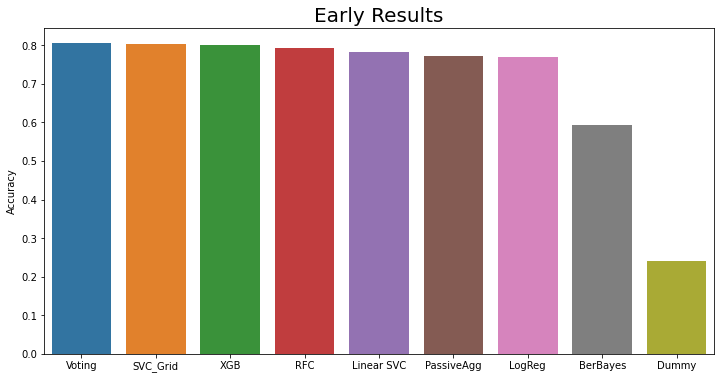

In [164]:
plt.figure(figsize=(12,6))
sns.barplot(x,y)
plt.ylabel('Accuracy')
plt.title("Early Results", fontsize=20)
#plt.savefig("../pics/model_performances.png")